In [1]:
%load_ext lab_black

# ERCOT HDD

In this notebook we will look at the return period of the heating demand days over the part of Texas that is in ERCOT, weighting by population from various years or not at all

In [2]:
import os

from labellines import labelLines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
from scipy.stats import genextreme as gev
import xarray as xr

from codebase.calc import optimizer
from codebase.data import PARDIR
from codebase.fig import smart_save, add_panel_text

In [3]:
hdd = xr.open_dataset(
    os.path.join(PARDIR, "data", "processed", "era5", "tx", "hdd_ercot.nc")
)
hdd

<xarray.Dataset>
Dimensions:        (pop_year: 5, time: 154942)
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 ... 2021-02-17T21:00:00
  * pop_year       (pop_year) int64 2000 2005 2010 2015 2020
Data variables:
    pop_weighted   (time, pop_year) float64 ...
    area_weighted  (time) float64 ...

This data contains area averages over ERCOT, weighted either by population or by area

## IDF Curves

We're going to construct IDF Curves for several data sets.
First, we will need to compute the HDD at various lags.
Our data is hourly

In [4]:
DURATIONS = np.concatenate(
    [range(1, 5), range(4, 13, 2), range(12, 25, 4), range(24, 97, 8)]
)
hdd_roll = xr.concat(
    [
        hdd.rolling(time=duration).mean().assign_coords({"duration": duration})
        for duration in DURATIONS
    ],
    dim="duration",
)

Next we will construct annual maximum time series

In [5]:
# group together December YYYY and Jan YYYY+1
times = pd.to_datetime(hdd_roll["time"].values)
year_eff = times.year + np.int_(times.month > 7)
hdd_roll["year_eff"] = xr.DataArray(
    year_eff, coords={"time": hdd_roll["time"]}, dims="time"
)
hdd_annual = hdd_roll.groupby("year_eff").max(dim="time")

In [6]:
RETURN_PERIODS = [2, 5, 10, 25, 50, 100]

In [7]:
def calc_plotposition_return_level(X, T):
    """Use a formula for plot position rather than MLE GEV fit"""
    KT = -np.sqrt(6) / np.pi * (0.5772 + np.log(np.log(T / (T - 1))))
    Xbar = np.mean(X)
    S = np.std(X)
    return Xbar + KT * S

In [8]:
def calc_mle_return_level(X, T):
    theta = gev.fit(
        X,
        0,
        loc=40,
        scale=10,
        optimizer=optimizer,
    )
    return gev(*theta).isf(1 / T)

In [9]:
plot_info = [
    [
        hdd_annual["pop_weighted"].sel(pop_year=2020),
        "Average Heating Demand Over ERCOT, Pixels Weighted by 2020 Population",
        calc_mle_return_level,
        "ERCOT_HDD_IDF_MLE_popweighted",
    ],
    [
        hdd_annual["area_weighted"],
        "Average Heating Demand Over ERCOT, Pixels Weighted by Area",
        calc_mle_return_level,
        "ERCOT_HDD_IDF_MLE_unweighted",
    ],
    [
        hdd_annual["pop_weighted"].sel(pop_year=2020),
        "Average Heating Demand Over ERCOT, Pixels Weighted by 2020 Population",
        calc_plotposition_return_level,
        "ERCOT_HDD_IDF_plotpos_popweighted",
    ],
    [
        hdd_annual["area_weighted"],
        "Average Heating Demand Over ERCOT, Pixels Weighted by Area",
        calc_plotposition_return_level,
        "ERCOT_HDD_IDF_plotpos_unweighted",
    ],
]

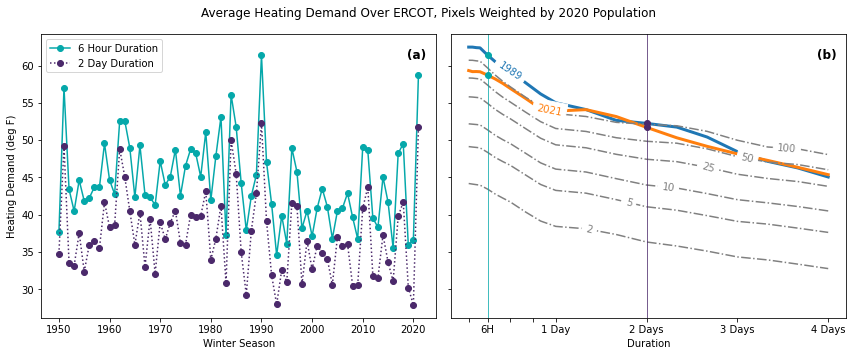

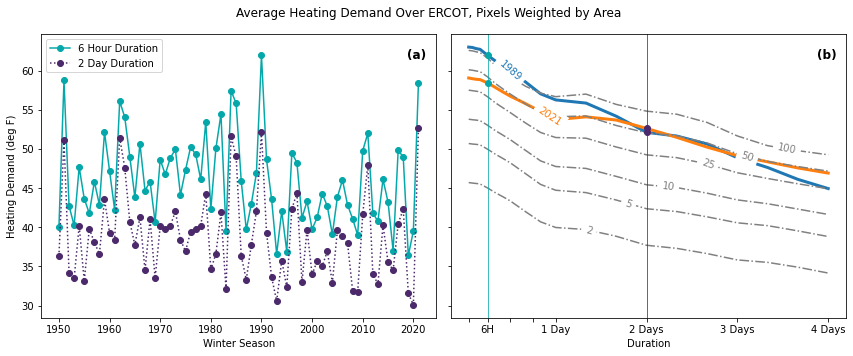

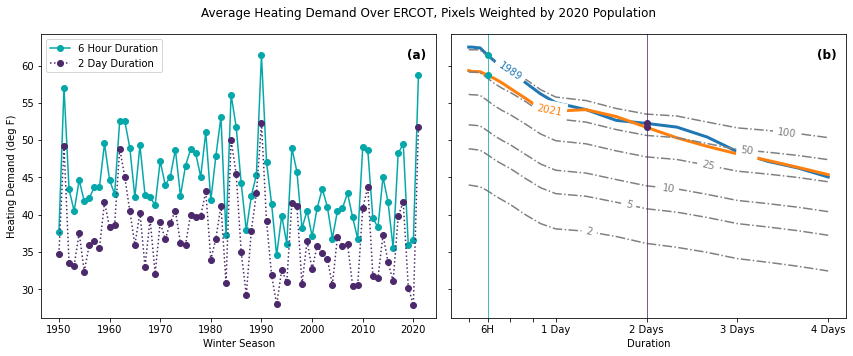

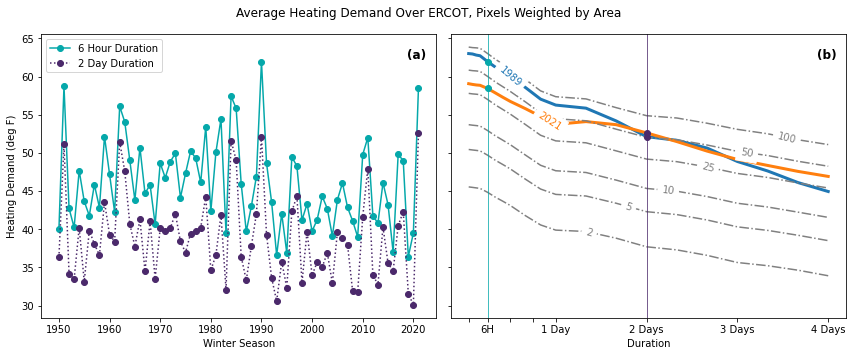

In [10]:
for obs, title, return_level, fname in plot_info:

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 5), sharey=True, sharex=False
    )

    # Plot Time Series
    ax = axes[0]
    obs.sel(duration=6).plot(
        ax=ax, label="6 Hour Duration", color="#05A8AA", marker="o"
    )
    obs.sel(duration=48).plot(
        ax=ax, label="2 Day Duration", color="#4B296B", linestyle=":", marker="o"
    )
    ax.set_ylabel("Heating Demand (deg F)")
    ax.legend(loc="upper left")
    ax.set_title("")
    ax.set_xlabel("Winter Season")

    # Plot IDF CURVE
    ax = axes[1]
    obs.sel(year_eff=1990).plot(
        ax=ax, label="1989", linewidth=3
    )  # Dec 1989 is coded as 1990 here
    obs.sel(year_eff=2021).plot(ax=ax, label="2021", linewidth=3)
    for rp in RETURN_PERIODS:
        ax.plot(
            DURATIONS,
            [
                return_level(
                    X=obs.sel(duration=duration, year_eff=slice(0, 2020)).values, T=rp
                )
                for duration in DURATIONS
            ],
            label=rp,
            color="gray",
            linestyle="-.",
        )

    labelLines(ax.get_lines(), zorder=2.5)

    # dots to correspand with panel (a)
    for year_eff in [1990, 2021]:
        for duration, color in zip([6, 48], ["#05A8AA", "#4B296B"]):
            ax.plot(
                duration,
                float(obs.sel(duration=duration, year_eff=year_eff)),
                color=color,
                marker="o",
            )
            ax.axvline(duration, color=color, linewidth=0.5)

    ax.set_xlabel("Duration")
    ax.set_xticks([1, 6, 12, 18, 24, 48, 72, 96])
    ax.set_xticklabels(["", "6H", "", "", "1 Day", "2 Days", "3 Days", "4 Days"])
    ax.set_title("")
    ax.set_ylabel("")

    add_panel_text(
        axes,
        backgroundcolor="white",
        fontsize=12,
    )
    # Add  color bars

    fig.subplots_adjust(top=0.925)
    fig.suptitle(title)

    fig.canvas.draw()
    fig.tight_layout()
    smart_save(fname)
    plt.show()